# Pb scavenging

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc
import xarray as xr
import cmocean
import modules.mapping_functions as mf
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

#### Parameters / settings:

In [1]:
# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179
isize = imax - imin
jsize = jmax - jmin

# colors:
colors = ['#f6c6bb', '#fa654a', '#e9bb65', '#78add6']
color  = ['#00cc99', '#138484', '#0099ff', '#0d55ad', '#b6cce6', '#cc99cc', '#9966cc', '#5b3d7a', '#cdc4d7']
land_color = '#a9a7a2'

#### Load files

In [4]:
# Modified ANHA12 mesh mask file (http://knossos.eas.ualberta.ca/anha/anhatable.php)
mesh         = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20220317.nc')
mesh_lon     = mesh['nav_lon'].values
mesh_lat     = mesh['nav_lat'].values
mesh_bathy   = mesh['tmask'][0,:,:,:].values
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
ocean_masked = np.ma.masked_where((mesh_bathy<0.1), mesh_bathy)
depths       = mesh['nav_lev'].values

In [ ]:
# Scavenging forcing created by forcing/scavenging-forcing.ipynb
scav_file = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/Pb-20220907/Pb_scavenging_y{year}m{month:02}.nc')

Pb residence time estimates from the literature:
(Observations summary table: https://www.overleaf.com/read/pwyprcnqqscp)

In [7]:
# Kadko et al., 2018: collected August 20 - October 5, 2015
kadko_lats   = np.array([76.511, 79.997, 83.755, 87.520, 88.407, 89.987, 87.815, 85.135, 82.491, 80.369, 78.180, 77.503, 76.998, \
                76.505, 73.506, 73.008])
kadko_lons   = np.array([-173.034, -174.962, 174.915, -179.809, -176.761, -89.25, -149.734, -150.063, -149.872, -149.855, -147.831, -148.009, -148.803, \
               -149.515, -156.808, -158.729])
kadko_depths = np.array([56, 52, 52, 46, 20, 23, 45, 41, 47, 49, 40, 47, 40, 40, 46, 36])
kadko_res    = np.array([0.69, 0.76, 0.94, 0.24, 0.76, 0.27, 0.33, 0.71, 1.07, 0.65, 0.31, 0.36, 0.41, 0.28, 0.38, 0.18])

In [8]:
# Chen et al., 2012: 
chen_lats   = np.array([69.996, 73.998, 68.919, 70.495, 71.579, 71.261, 73.995, 73.380])
chen_lons   = np.array([-168.999, -168.991, -167.009, -162.976, -164.013, -150.376, -156.332, -151.883])
chen_depths = np.array([30, 40, 10, 30, 40, 20, 30, 100])
chen_res    = np.array([0.05, 0.10, 0.01, 0.15, 0.03, 0.10, 0.23, 0.28])

In [9]:
kadko_ANHA12_i, kadko_ANHA12_j = mf.find_indeces_vector(kadko_lons, kadko_lats, ANHA12_lons, ANHA12_lats) #find_index_ANHA12(kadko_lons, kadko_lats)
chen_ANHA12_i,  chen_ANHA12_j  = mf.find_indeces_vector(chen_lons, chen_lats, ANHA12_lons, ANHA12_lats) #find_index_ANHA12(chen_lons, chen_lats)

In [10]:
# Bacon et al., 1976: Atlantic Ocean
Bacon_depth   = [300, 4880, 5003, 3820, 4940, 4950, 4440] # marked by top and bottom of range
Bacon_restime = [2.3, 20, 21, 54, 93, 90, 60]

# Henderson and Maier-Reimer, 2002: North Atlantic
HMR_depth   = [75, 2000]
HMR_restime = [3, 30] 

# Moore and Smith, 1986: 
MS_depth   = [200, 1770]
MS_restime = [5, 21] 

# Ones with only surface, intermediate or deep defined:
sid_depth = [5, 1500, 3000]
craig_restime   = [2, np.nan, 54]   # Craig et al., 1973; Pacific Ocean
nozaki_restime  = [1.7, 15, 100]    # Nozaki et al., 1976, 1990; Pacific Ocean
schaul_restime  = [1.6, np.nan, 50] # Schaule and Patterson, 1983; Sargasso Sea
schaul1_restime = [np.nan, 20, 80]  # Schaule and Patterson, 1981; North Pacific
shen_restime    = [2.5, np.nan, np.nan] # Shen and Boyle, 1988; Bermuda

#### Functions:

In [11]:
def plot_residence_time(fig, ax, res_time, depth_slice=(0,18), maxv=1.0):
    res_time_slice = np.mean(res_time[depth_slice[0]:depth_slice[1],:,:], axis=0)

    proj=Basemap(projection='eqdc',lat_0 = 73, lon_0 = -78, resolution='i', width=5.4e6, height=4.3e6, ax=ax)
    proj.drawcoastlines(color='#373736', linewidth=1.0);
    proj.fillcontinents(color=land_color, lake_color=land_color, zorder=5);
    
    x, y = proj(mesh_lon, mesh_lat)
    proj.contourf(x, y, bathy_masked[depth_slice[1],:,:], colors=[land_color]) # Mask land at particular depth

    # Show Arctic Ocean observed residence times only if depth slice shown goes shallower than 60 m.
    if depth_slice[0] < 17:
        x_kadko, y_kadko = proj(kadko_lons, kadko_lats)
        x_chen,  y_chen  = proj(chen_lons, chen_lats)
        CB = proj.scatter(x_kadko, y_kadko, c=kadko_res, s=20, edgecolor='w', linewidth=0.5, \
                          zorder=5, vmin=0, vmax=maxv, cmap=cmocean.cm.matter)
        proj.scatter(x_chen, y_chen, c=chen_res, s=20, edgecolor='w', linewidth=0.5, \
                     zorder=5, vmin=0, vmax=maxv, cmap=cmocean.cm.matter)

    # Model residence time estimate:
    x_ANHA12, y_ANHA12 = proj(ANHA12_lons, ANHA12_lats)
    CB2 = proj.pcolormesh(x_ANHA12, y_ANHA12, res_time_slice, cmap=cmocean.cm.matter, vmin=0, vmax=maxv)
        
    # Colorbar:
#     cbaxes2 = fig.add_axes([0.25, 0.17, 0.03, 0.23]) 
    CBar2 = plt.colorbar(CB2, ax=ax, orientation='vertical', shrink=0.5)
    CBar2.ax.tick_params(labelsize=6) 
    CBar2.set_label('Residence time [years]', fontsize=6)
    
    ax.set_title(f'Depth slice: {depths[depth_slice[0]]:.0f}-{depths[depth_slice[1]]:.0f} m', fontsize=6)
   
    return

In [13]:
# composition recipe:
def estimate_residence_time(beta, constant):
    
    particles = (1-beta)*normalized_biogenic + beta*normalized_lithogenic
    particles[particles <= 0] = np.nan
    particles[particles < 5e-5] = 5e-5 # no smaller
    
    modelled_res_time = 1 / (constant*particles)
    modelled_res_time[mesh_bathy[:,imin:imax,jmin:jmax] < 0.1] = np.nan ### uses old dimension coordinates
    
    return modelled_res_time/(3600*24*365)

### Particle estimates:

In [14]:
ANHA12_biomass = np.empty((50,isize,jsize))
for depth in range(0,50):
    ANHA12_biomass[depth,:,:] = mf.interp_np_zero(ANHA4_lons.flatten(), ANHA4_lats.flatten(), \
                                                  biomass[depth,:,:].flatten(), ANHA12_lons, ANHA12_lats)
    
ANHA12_biomass[ANHA12_biomass < 0] = 0

In [18]:
m_res_time1 = estimate_residence_time(0.35, 0.95e-5)
m_res_time2 = estimate_residence_time(0.04, 0.9e-5)
m_res_time3 = estimate_residence_time(0.05, 0.9e-5)

m_res_time_ave1 = np.nanmean(m_res_time1[:,:,:],axis=(1,2))
m_res_time_ave2 = np.nanmean(m_res_time2[:,:,:],axis=(1,2))
m_res_time_ave3 = np.nanmean(m_res_time3[:,:,:],axis=(1,2))

print(f'Modelled residence time 1: {np.nanmin(m_res_time1):.2f}-{np.nanmax(m_res_time1):.2f}, mean: {np.nanmean(m_res_time1):.2f}')
print(f'Modelled residence time 2: {np.nanmin(m_res_time2):.2f}-{np.nanmax(m_res_time2):.2f}, mean: {np.nanmean(m_res_time2):.2f}')
print(f'Modelled residence time 3: {np.nanmin(m_res_time3):.2f}-{np.nanmax(m_res_time3):.2f}, mean: {np.nanmean(m_res_time3):.2f}')

Modelled residence time 1: 0.01-66.76, mean: 0.77
Modelled residence time 2: 0.00-70.47, mean: 4.85
Modelled residence time 3: 0.00-70.47, mean: 3.98


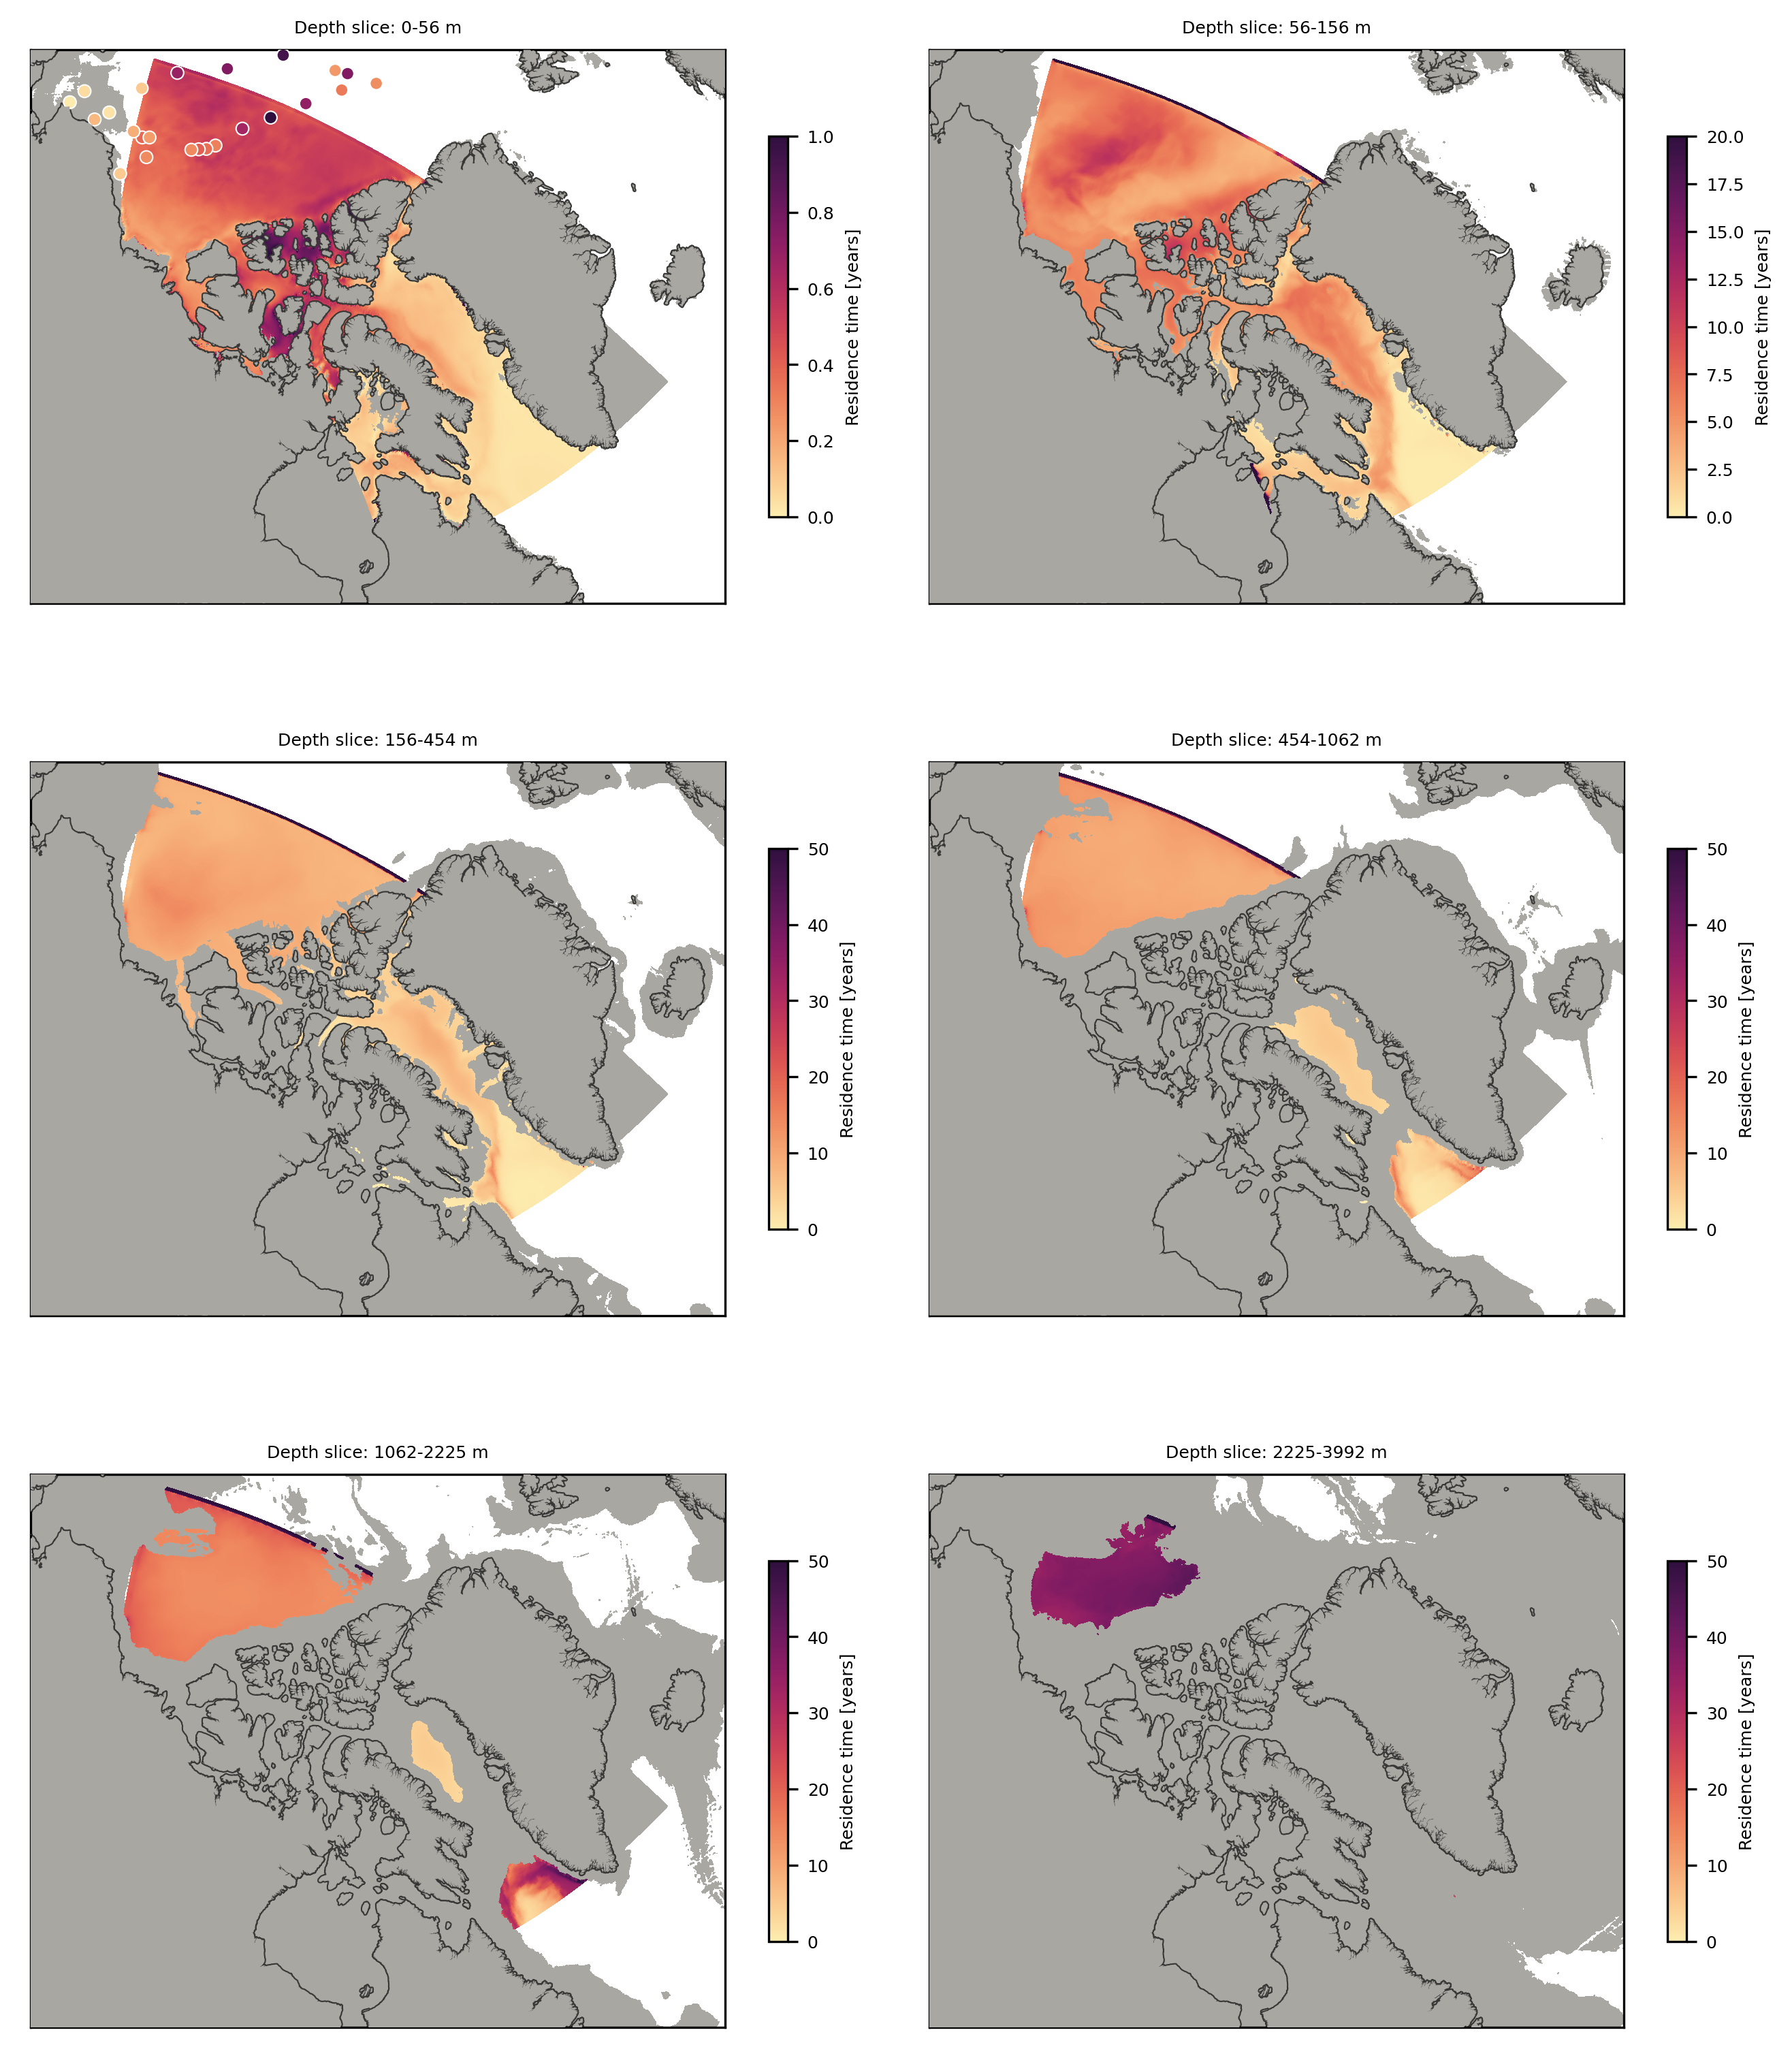

In [19]:
fig, ax = plt.subplots(3,2,figsize=(9, 11), dpi=300)

plot_residence_time(fig, ax[0,0], m_res_time2, depth_slice=(0,18) , maxv=1)
plot_residence_time(fig, ax[0,1], m_res_time2, depth_slice=(18,24), maxv=20)
plot_residence_time(fig, ax[1,0], m_res_time2, depth_slice=(24,30), maxv=50)
plot_residence_time(fig, ax[1,1], m_res_time2, depth_slice=(30,35), maxv=50)
plot_residence_time(fig, ax[2,0], m_res_time2, depth_slice=(35,40), maxv=50)
plot_residence_time(fig, ax[2,1], m_res_time2, depth_slice=(40,45), maxv=50)

plt.tight_layout(h_pad=-0.1)
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb_chapter/residence_time_profile.jpg', bbox_inches='tight', dpi=300)

(5000.0, 0.0)

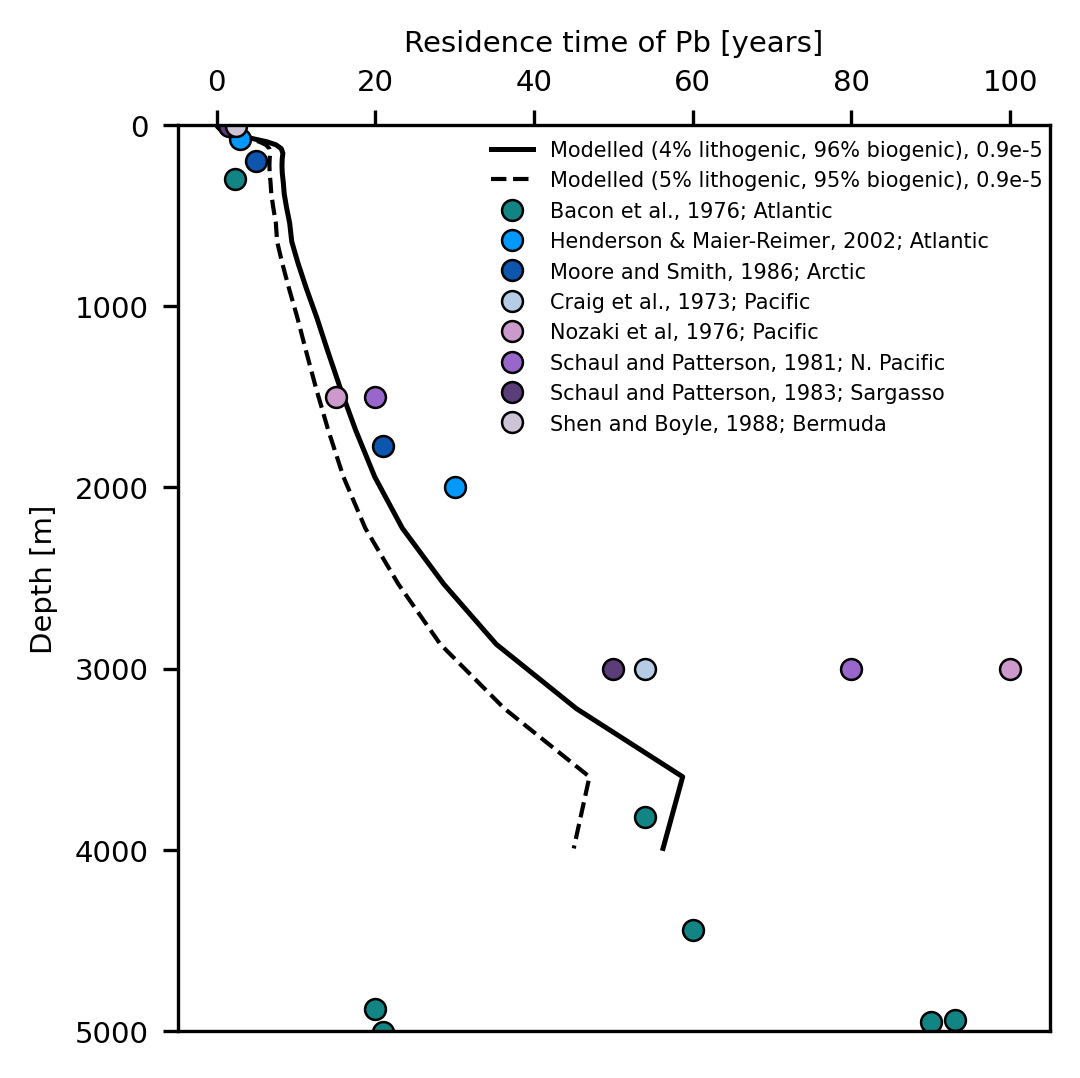

In [21]:
fig, ax = plt.subplots(1,1, figsize=(3.75,4.0), dpi=300)

# Model:
ax.plot(m_res_time_ave2, depths, '-', c='k', linewidth=1.2, label='Modelled (4% lithogenic, 96% biogenic), 0.9e-5')
ax.plot(m_res_time_ave3, depths, '--',  c='k', linewidth=1.0, label='Modelled (5% lithogenic, 95% biogenic), 0.9e-5')

# Observations:
ax.plot(Bacon_restime, Bacon_depth,'.', markeredgecolor='k', markeredgewidth=0.6, c=color[1], \
        label='Bacon et al., 1976; Atlantic', markersize=10)
ax.plot(HMR_restime, HMR_depth,'.', markeredgecolor='k', markeredgewidth=0.6, c=color[2], \
        label='Henderson & Maier-Reimer, 2002; Atlantic', markersize=10)
ax.plot(MS_restime, MS_depth,'.', markeredgecolor='k', markeredgewidth=0.6, c=color[3], \
        label='Moore and Smith, 1986; Arctic', markersize=10)
ax.plot(craig_restime,  sid_depth,'.', markeredgecolor='k', markeredgewidth=0.6, c=color[4], \
        label='Craig et al., 1973; Pacific', markersize=10)
ax.plot(nozaki_restime, sid_depth,'.', markeredgecolor='k', markeredgewidth=0.6, c=color[5], \
        label='Nozaki et al, 1976; Pacific', markersize=10)
ax.plot(schaul1_restime, sid_depth,'.', markeredgecolor='k', markeredgewidth=0.6, c=color[6], \
        label='Schaul and Patterson, 1981; N. Pacific', markersize=10)
ax.plot(schaul_restime, sid_depth,'.', markeredgecolor='k', markeredgewidth=0.6, c=color[7], \
        label='Schaul and Patterson, 1983; Sargasso', markersize=10)
ax.plot(shen_restime, sid_depth,'.', markeredgecolor='k', markeredgewidth=0.6, c=color[8], \
        label='Shen and Boyle, 1988; Bermuda', markersize=10)

# general settings:
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.tick_params(labelsize=7)
ax.set_xlabel('Residence time of Pb [years]', fontsize=7)
ax.set_ylabel('Depth [m]', fontsize=7)
ax.legend(loc=(0.35, 0.65), fontsize=5.0, frameon=False)
ax.set_ylim(5000,0)

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb_chapter/residence_time_profile.jpg', bbox_inches='tight', dpi=300)